# Tutorial 5 - Text analysis of COP tweets

Week 2, Day 3: IPCC Socio-economic Basis

By Neuromatch Academy

Content creators: Name Surname, Name Surname, Maximilian Puelma Touzel

Content reviewers: Name Surname, Name Surname

Content editors: Name Surname, Name Surname

Production editors: Name Surname, Name Surname

Our 2023 Sponsors

---
# Tutorial Objective 

Learn to assess public sentiment about climate change and how it is changing by analyzing changes in word use on social media. An auxillary objective is to learn how to load and analyze large amounts of text

---
# Setup

Import libraries



In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
sns.set_style("ticks", {'axes.grid' : False})
#notebook config
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.display import Math
import glob
import time
import datetime
import os
import re
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import urllib3
import urllib.request  # the lib that handles the url stuff
!pip install afinn
from afinn import Afinn


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Mount local drive

In [2]:
# Mount Google Drive locally
from google.colab import drive
drive.mount('/content/drive')

data_dir = '/content/drive/Shareddrives/Academy/Courses/Climate/Climatematch/02-Curriculum/Climatematch Content Folder/W2D3 - Future Climate - IPCC II & III (Socio-Economic Basis) /W2D3 Tutorials/day8_tutorial4_sentiment_analysis/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Helper functions

## Data preprocessing

We have done the following preprocessing steps for you (just read along; no need to run anything in this section):

Twitter ids of tweets mentioning COPx (x=20-26) used in Falkenberg et al. (2022) were placed by the authors in an osf archive: https://osf.io/nu75j. Download the 7 .csv files (one for each COP) here: https://osf.io/download/pr29x/ 

The program `twarc2` interfaces with the Twitter API. It can be used to hydrate the tweets (i.e. download the full tweet and metadata using the provided tweet id). Similar to github you have to open a Twitter API account and set up twarc on your local machine by giving it your account authentication keys. The command to rehyrdate a set of tweets from their ids is simply `twarc2 hydrate source_file.txt store_file.jsonl`, where each line of `source_file.txt` is a Twitter id and `store_file.jsonl` is where the hydrated tweets are stored.

- First format the downloaded ids and split them into seperate files (*batches*) to make hydration calls to the API more time manageable (hours versus days - this is slow because of an API-imposed limit of 100 tweets/min.). 

In [3]:
# dir_name='Falkenberg2022_data/'
# if not os.path.exists(dir_name):
#     os.mkdir(dir_name)
# batch_size = int(1e5)
# download_pathname=''#~/projects/ClimateMatch/SocioEconDay/Polarization/COP_Twitter_IDs/
# for copid in range(20,27):
#     df_tweetids=pd.read_csv(download_pathname+'tweet_ids_cop'+str(copid)+'.csv')    
#     for batch_id,break_id in enumerate(range(0,len(df_tweetids),batch_size)):
#         file_name="tweetids_COP"+str(copid)+"_b"+str(batch_id)+".txt"
#         df_tweetids.loc[break_id:break_id+batch_size,'id'].to_csv(dir_name+file_name,index=False,header=False)

- Make the hydration calls for a COP (this took 4 days to download 50GB of data for COP26).

In [4]:
# copid=26
# filename_list = glob.glob('Falkenberg2022_data/'+"tweetids_COP"+str(copid)+"*")
# dir_name='tweet_data/'
# if not os.path.exists(dir_name):
#     os.mkdir(dir_name)
# file_name="tweetids_COP"+str(copid)+"_b"+str(batch_id)+".txt"
# for itt,tweet_id_batch_filename in enumerate(filename_list):
#     strvars=tweet_id_batch_filename.split('/')[1].split('.')[0].split('_')
#     tweet_store_filename = dir_name+'tweets_'+strvars[1]+'_'+strvars[2]+'.json'
#     if not os.path.exists(tweet_store_filename):
#         st=time.time()
#         os.system('twarc2 hydrate '+tweet_id_batch_filename+' '+tweet_store_filename)
#         print(str(itt)+' '+str(strvars[2])+" "+str(time.time()-st))

- Load data

Inspect and pick a chunk size. Note, by default there are 100 tweets per line in the .json files returned by the API. Given we asked for 1e5 tweets/batch, there should be 1e3 lines in these files.

In [5]:
# copid=26
# batch_id = 0
# tweet_store_filename = 'tweet_data/tweets_COP'+str(copid)+'_b'+str(batch_id)+'.json'
# num_lines = sum(1 for line in open(tweet_store_filename))
# num_lines

Now we read in the data, iterating over chunks in each batch and only store the needed data in a dataframe (takes 10-20 minutes to run). Let's look at when the tweets were posted, what language they are in, and the tweet text:

In [6]:
# selected_columns = ['created_at','lang','text']

In [7]:
# st=time.time()
# filename_list = glob.glob('tweet_data/'+"tweets_COP"+str(copid)+"*")
# df=[]
# for tweet_batch_filename in filename_list[:-1]:
#     reader = pd.read_json(tweet_batch_filename, lines=True,chunksize=1)
# #     df.append(pd.DataFrame([item[selected_columns] for sublist in reader.data.values.tolist()[:-1] for item in sublist] )[selected_columns])
#     dfs=[]
#     for chunk in reader:
#         if 'data' in chunk.columns:
#             dfs.append(pd.DataFrame(list(chunk.data.values)[0])[selected_columns])
#     df.append(pd.concat(dfs,ignore_index=True))
# #     df.append(pd.DataFrame(list(reader.data)[0])[selected_columns])
# df=pd.concat(df,ignore_index=True)
# df.created_at=pd.to_datetime(df.created_at)
# print(str(len(df))+' tweets took '+str(time.time()-st))
# df.head()

- finally store the data in the efficiently compressed feather format

In [8]:
# df.to_feather('stored_tweets') 

# Analysis (run notebook from here)

# Section 1: load and inspect data

Load the preprocessed data

In [9]:
df=pd.read_feather(data_dir+'stored_tweets')

Let's check the timing of the tweets relative to the COP26 event to see how the tweets are spread over time.

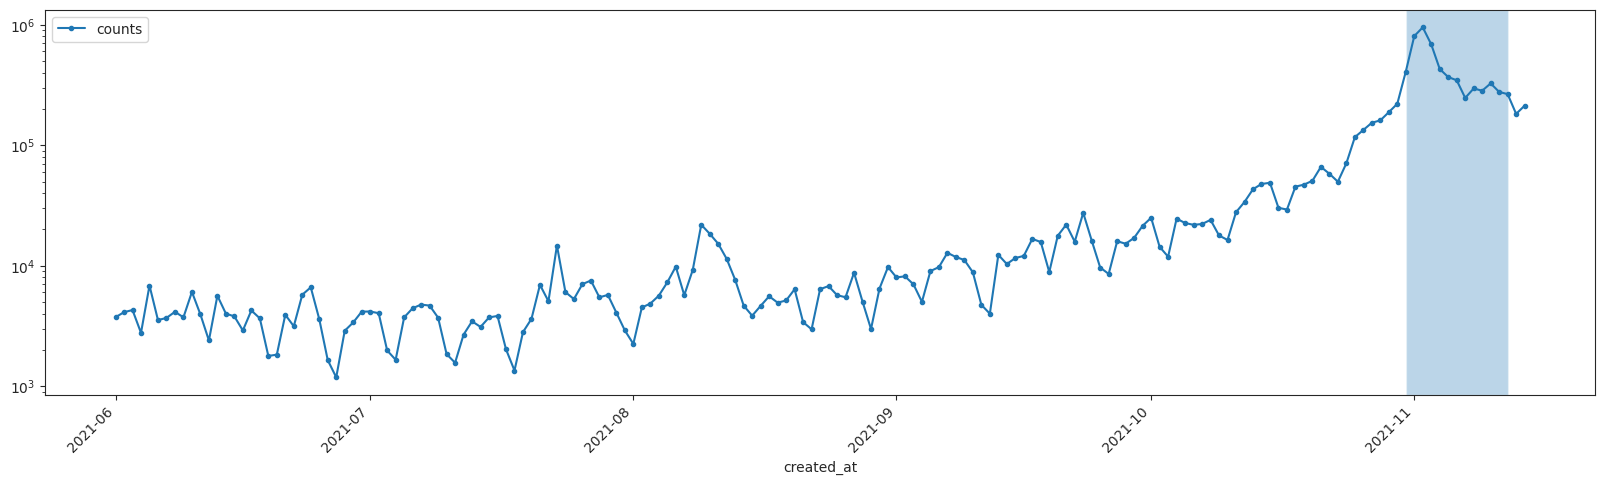

In [10]:
total_tweetCounts=df.created_at.groupby(df.created_at.apply(lambda x: x.date)).count().rename('counts')
total_tweetCounts.reset_index().plot(x='created_at',y='counts',figsize=(20,5),style='.-') 
pl.xticks(rotation=45,ha='right');
pl.gca().set_yscale('log')
COPdates=[datetime.datetime(2021,10,31), datetime.datetime(2021,11,12)] #shade the duration of the COP26 to guide the eye
pl.gca().axvspan(*COPdates, alpha=0.3); #gray region

Who is tweeting about this COP? Look at how many tweets were posted in various languages:

In [11]:
counts=df.lang.value_counts().reset_index()

The stored language name of the tweet is stored as a code name. Pull a language code dictionary from the web and use it to translate the language code to the language name.

In [12]:
target_url='https://gist.githubusercontent.com/carlopires/1262033/raw/c52ef0f7ce4f58108619508308372edd8d0bd518/gistfile1.txt'
exec(urllib.request.urlopen(target_url).read())
lang_code_dict=dict(iso_639_choices)
counts=counts.replace({'index':lang_code_dict})
counts

,index,lang
0,English,6570754
1,Spanish; Castilian,742064
2,French,321012
3,Japanese,229586
4,Portuguese,165717
...,...,...
66,"Pashto, Pushto",23
67,Georgian,22
68,Tibetan,16
69,Sindhi,7


*Exercise*: find your native language code in the dictionary and use it to select the COP tweets that were written in your language!

In [13]:
lang_code_dict

{'ab': 'Abkhaz',
 'aa': 'Afar',
 'af': 'Afrikaans',
 'ak': 'Akan',
 'sq': 'Albanian',
 'am': 'Amharic',
 'ar': 'Arabic',
 'an': 'Aragonese',
 'hy': 'Armenian',
 'as': 'Assamese',
 'av': 'Avaric',
 'ae': 'Avestan',
 'ay': 'Aymara',
 'az': 'Azerbaijani',
 'bm': 'Bambara',
 'ba': 'Bashkir',
 'eu': 'Basque',
 'be': 'Belarusian',
 'bn': 'Bengali',
 'bh': 'Bihari',
 'bi': 'Bislama',
 'bs': 'Bosnian',
 'br': 'Breton',
 'bg': 'Bulgarian',
 'my': 'Burmese',
 'ca': 'Catalan; Valencian',
 'ch': 'Chamorro',
 'ce': 'Chechen',
 'ny': 'Chichewa; Chewa; Nyanja',
 'zh': 'Chinese',
 'cv': 'Chuvash',
 'kw': 'Cornish',
 'co': 'Corsican',
 'cr': 'Cree',
 'hr': 'Croatian',
 'cs': 'Czech',
 'da': 'Danish',
 'dv': 'Divehi; Maldivian;',
 'nl': 'Dutch',
 'dz': 'Dzongkha',
 'en': 'English',
 'eo': 'Esperanto',
 'et': 'Estonian',
 'ee': 'Ewe',
 'fo': 'Faroese',
 'fj': 'Fijian',
 'fi': 'Finnish',
 'fr': 'French',
 'ff': 'Fula',
 'gl': 'Galician',
 'ka': 'Georgian',
 'de': 'German',
 'el': 'Greek, Modern',
 'gn': '

Select tweets of a given language

In [14]:
language_code = 'en'
df=df.loc[df.lang==language_code,:].reset_index(drop=True)
pd.options.display.max_rows=100 #see up to 100 entries
pd.options.display.max_colwidth=250 #widen how much text is presented of each tweet
df.sample(100)

,created_at,lang,text
1101841,2021-07-30 07:16:21+00:00,en,"RT @CenterForBioDiv: Today is Earth #OvershootDay. For 100 days between now and @COP26, @endovershoot highlights ways for each country, cit…"
3984594,2021-11-03 13:21:42+00:00,en,"RT @350Europe: Pacific Climate Warrior @Brianna_Fruean of @350Pacific spoke at the #COP26 UN climate conference today.\n\n""We are not drownin…"
4470293,2021-11-05 01:13:32+00:00,en,RT @GreenpeaceUK: 'This is greenwashing!' Greta Thunberg calls out @shell @bp_plc and the big banks' #COP26 carbon offsetting panel. \n\nCarb…
2200739,2021-10-31 19:17:07+00:00,en,"RT @COP26: ""Staying below 1.5 degrees is the only chance we have of avoiding these tipping points and stabilising our world again""\n\nHear fr…"
5614129,2021-11-09 15:44:01+00:00,en,"Checkpoint 11 and final one on Day 2 on #EVROS at Kinlochleven community toilets. Nearly done for today, should finish on about 166 miles for the day when we roll in to Fort William.\n\n@Vanarama\n\n@TheEVROS #COP26 #TogetherForOurPlanet https://..."
636191,2021-10-16 02:24:07+00:00,en,"This is the bullshit we’ve had to content with the last 8 miserable years.\nPlease do what ever you need to, to punish this man @COP26 https://t.co/7H5Gr8GnkT"
5342606,2021-11-08 11:23:43+00:00,en,Methane (CH4) accounts for 30% of the net rise in global temperature. You can help mitigate methane emissions! Read more about methane and join the climate action by clicking on this link: https://t.co/lCopYJe9Q0\n#COP26\n#climatechange\n#methane...
4684745,2021-11-05 15:19:05+00:00,en,'It is thought that one million animal and plant species - almost a quarter of the global total - are threatened with extinction.' https://t.co/R8XSgwkimM #RewildCities #COP26 #rewilding https://t.co/x4Iy2QJpHX
4942526,2021-11-06 15:59:04+00:00,en,@maarten_dezeeuw @GretaThunberg @COP26_Coalition Go Go Go....
5570939,2021-11-09 12:08:23+00:00,en,It's great to see people across different communities coming together to support the #BillionSeedChallenge &amp; helping protect their local environment. \n\nSee more: https://t.co/wBkLMvSTa9\n\n#BetterwithNature #COP26 #TogetherForOurPlanet #Nature


## Section 2: Hypocrisy language

[Falkenberg et al.](https://www.nature.com/articles/s41558-022-01533-z) investigated the hypothesis that *public sentiment* around the COP conferences has increasingly framed them as hypocritical ("political hypocrisy as a topic of cross-ideological appeal"). The authors operationalized hypocrisy talk as any tweet containing any of the following words:

In [15]:
hypocrisy_words = ['hypocrisy', 'hypocrite', 'hypocritical', 'greenwash','green wash', 'blah'] #the last 3 words don't add much. Greta Thurnberg's 'blah, blah blah' speech on Sept. 28th 2021.

The authors then searched for these words within a distinct dataset across all COP conferences (that they did not make openly accessible; result: https://www.nature.com/articles/s41558-022-01527-x/figures/7). The results show that hypocrisy has been mentioned more.

How might this matching procedure be limited in its ability to capture this sentiment?

Here, we will instead focus on their acessible COP26 dataset and assess the nature of comments about specific topics, like political hypocrisy.

In [16]:
hypowords_detector = re.compile(r'\b(?:{0})\b'.format('|'.join(hypocrisy_words))) #compile for speed!
df['hypotalk']=df.text.apply(lambda x: hypowords_detector.search(x,re.IGNORECASE)) # look through whole dataset, flagging tweets with hypotalk (computes in under a minute)

Let's pull these tweets out and look at thier occurence statistics relative to those of the whole dataset computed above

In [17]:
hyp_tweets=df.loc[~df.hypotalk.isnull(),:]
hypo_tweet_counts=hyp_tweets.created_at.groupby(hyp_tweets.created_at.apply(lambda x: x.date)).count().rename('counts')
hypo_tweet_fraction=hypo_tweet_counts/total_tweetCounts

Text(0, 0.5, 'fraction talking about hypocrisy')

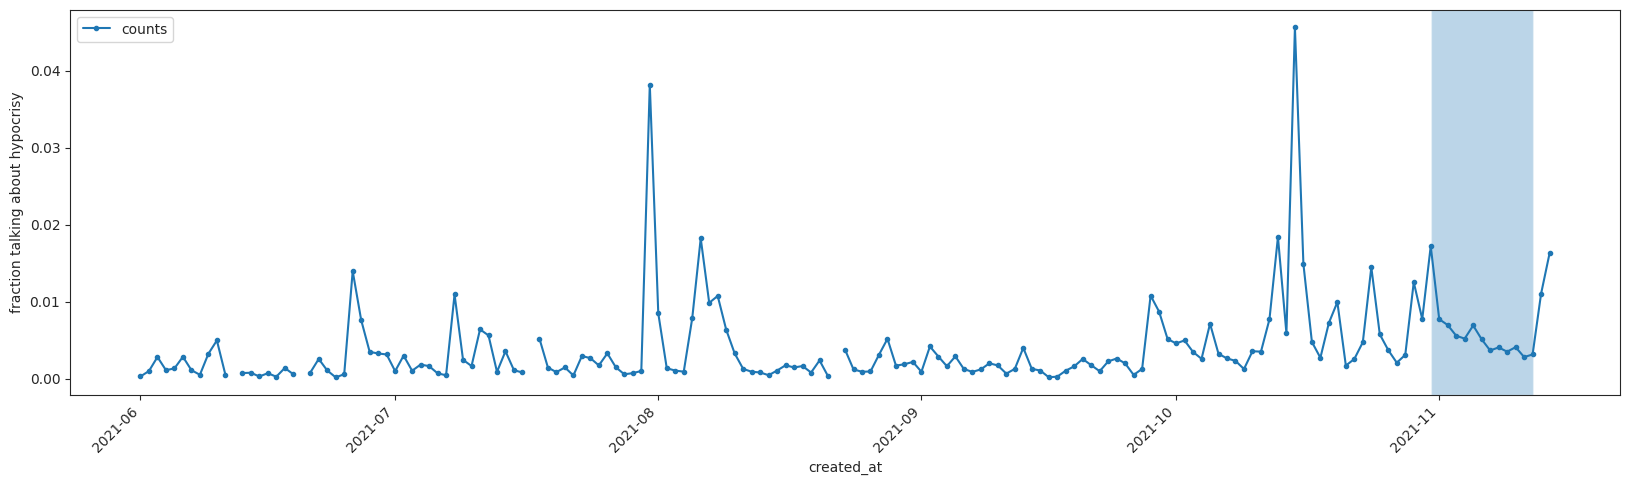

In [18]:
hypo_tweet_fraction.reset_index().plot(x='created_at',y='counts',figsize=(20,5),style=['.-']) #this doesn't 
pl.xticks(rotation=45,ha='right');
pl.gca().axvspan(*COPdates, alpha=0.3) #gray region
pl.gca().set_ylabel('fraction talking about hypocrisy')

Note these are normalized so larger fractions closer to the COP26 dates correspond to significantly more absolute number of tweets. 

Let's look at what these tweets say. Take 100 randomly sampled.

In [19]:
hyp_tweets.text.sample(100).values

array(["RT @ClimateAd: WATCH: 30+ years of blah blah blah.\n\n#COP26 needs to be more than just talk.\nIt's time to #EndFossilFuels https://t.co/LsRmX…",
       "RT @Greenpeace: 'Green' aviation? Nothing but greenwash.\n\nIndustry claims of carbon offsets for flights are just another scam to distract u…",
       'RT @Nigel_Farage: Every world leader or dignitary that arrives to @COP26 by private jet is an eco-hypocrite. Fact.',
       'They want you to use less, eat less, stay at home &amp; pay more tax, while getting less for it! This, meanwhile, demonstrates the utter #hypocrisy of #COP26Glasgow #COP26 #ThemAndUs  https://t.co/RqtTzAmrPU',
       'RT @greenbenali: The best antidote to blah blah blah at #COP26 is a Green Surge 💚 https://t.co/DXCMqZr01c',
       'RT @Nigel_Farage: Every world leader or dignitary that arrives to @COP26 by private jet is an eco-hypocrite. Fact.',
       "RT @LesleyRiddoch: Felt like walking round #COP26 with a sign saying 'I didn't vote for blah blah bla

*Exercise*: Pick another sentiment other than 'hypocrisy', and come up with a list of words for it to run the same analysis. E.g. "renewable technology"

## Section 3: Sentiment analysis

The hypocrisy displayed above seems charged against international organizations central to globalization (e.g. G7). Let's assess that hypothesis by analyzing the sentiment of the subset of these hypocrisy tweets that mention these institutions. 

(part of the computation flow in what follows was taken from Caren Neal's tutorial: https://nealcaren.org/lessons/wordlists/)

We'll match words in tweets to sentiment scores using a dictionary method. The particular dictionary we will use is compiled in the AFINN package. Let's initialize it for the language we've chosen

In [20]:
afinn = Afinn(language=language_code)

Load the dictionary

In [21]:
afinn_wl_url = ('https://raw.githubusercontent.com'
                '/fnielsen/afinn/master/afinn/data/AFINN-111.txt')
afinn_wl_df = pd.read_csv(afinn_wl_url,
                          header=None, # no column names
                          sep='\t',  # tab sepeated
                          names=['term', 'value']) #new column names
seed = 808 # seed for sample so results are stable
afinn_wl_df.sample(10, random_state = seed)

,term,value
1852,regret,-2
1285,indifferent,-2
681,disappoints,-2
770,doubts,-1
1644,outmaneuvered,-2
55,admit,-1
1133,haha,3
1160,haunt,-1
2435,wishing,1
21,abused,-3


let's look at the distribution of scores over all words in teh dictionary

Text(0, 0.5, 'dictionary counts')

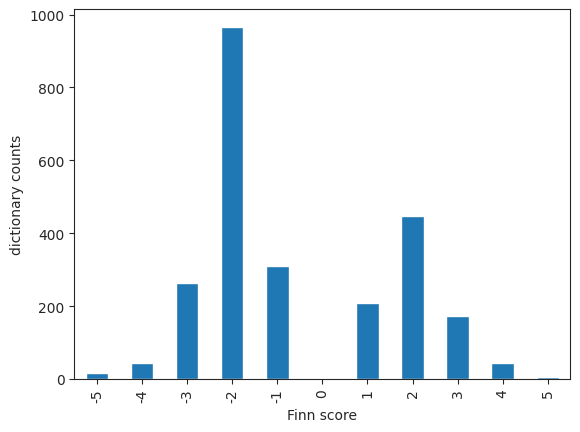

In [22]:
afinn_wl_df.value.value_counts().sort_index().plot.bar()
pl.gca().set_xlabel('Finn score')
pl.gca().set_ylabel('dictionary counts')

Before focussing on sentiments about institutions within the hypocrisy tweets, let's look at the hypocrisy tweets in comparison to non-hypocrisy tweets. This will take some more intensive computation, so let's only perform it on a 1% subsample of the dataset

In [23]:
smalldf=df.sample(frac=0.01)

In [24]:
smalldf['afinn_score'] = smalldf.text.apply(afinn.score) #intensive computation! 1 hrs 50 min long on full dataset! 1% takes about a minute

In [25]:
smalldf['afinn_score'].describe()

count    65708.000000
mean         0.406648
std          2.753001
min        -24.000000
25%         -1.000000
50%          0.000000
75%          2.000000
max         28.000000
Name: afinn_score, dtype: float64

The score is a sum over all words in the tweet so to compare we should convert to a per-word score by normalizing each tweet's score by its word count.

In [26]:
def word_count(text_string):
    '''Calculate the number of words in a string'''
    return len(text_string.split())
smalldf['word_count']=smalldf.text.apply(word_count)
smalldf['afinn_adjusted'] = smalldf['afinn_score'] / smalldf['word_count'] * 100

In [27]:
smalldf['afinn_adjusted'].describe()

count    65708.000000
mean         1.750699
std         12.707981
min       -128.571429
25%         -3.846154
50%          0.000000
75%          8.695652
max        150.000000
Name: afinn_adjusted, dtype: float64

Now let's look at the sentiment of tweets with hypocrisy words versus those without those words. We'll first plot for some other possibly negative words for reference.

In [28]:
for sel_words in [['Fossil'],['G7'],['Boris'],['Davos'],hypocrisy_words]:
    sel_name = sel_words[0] if len(sel_words)==1 else 'hypowords'
    hypowords_detector = re.compile(r'\b(?:{0})\b'.format('|'.join(sel_words))) #compile for speed!
    smalldf[sel_name] = smalldf.text.apply(lambda x: hypowords_detector.search(x,re.IGNORECASE) is not None) #flag if tweet has word(s)

make cumulative distribtion plots of score distributions

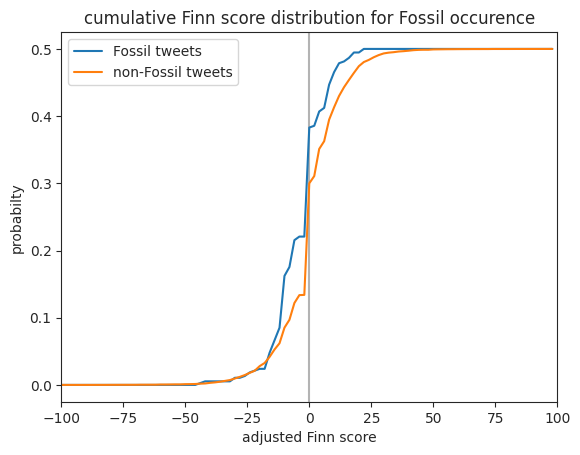

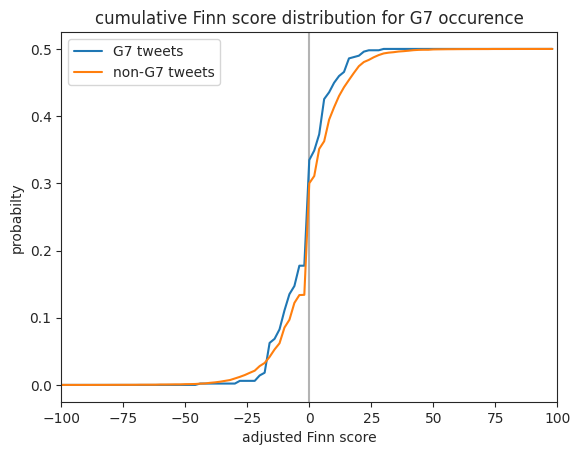

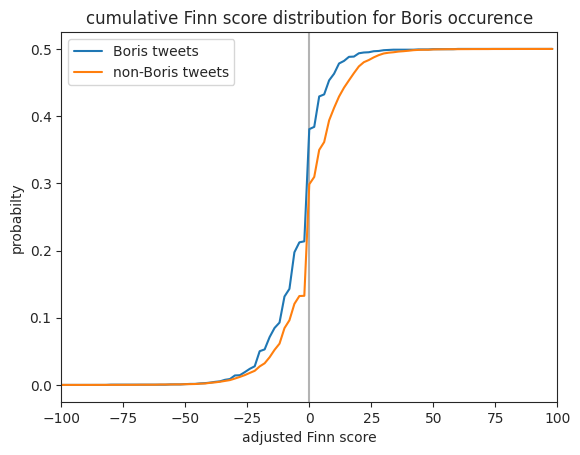

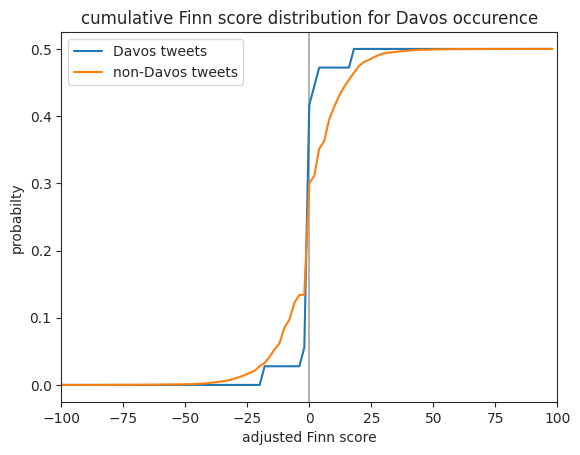

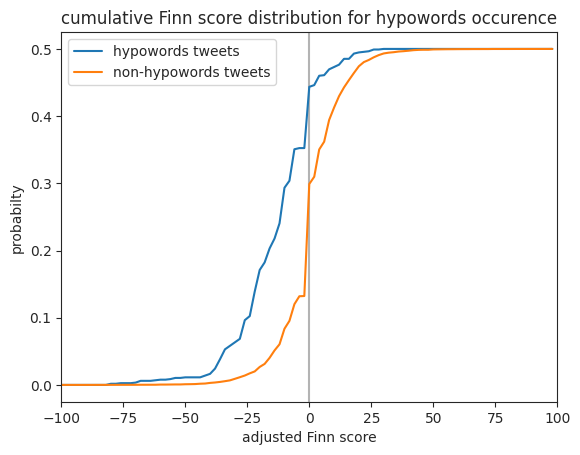

In [29]:
for sel_words in [['Fossil'],['G7'],['Boris'],['Davos'],hypocrisy_words]:
    sel_name =sel_words[0] if len(sel_words)==1 else 'hypowords'
    fig,ax=pl.subplots()
    pl.gca().set_xlim(-100,100)
    pl.gca().set_xlabel('adjusted Finn score')
    pl.gca().set_ylabel('probabilty')
    counts,bins=np.histogram(smalldf.loc[smalldf[sel_name],'afinn_adjusted'],bins=np.linspace(-100,100,101),density=True)
    pl.plot(bins[:-1],np.cumsum(counts),color='C0',label=sel_name+' tweets')
    counts,bins=np.histogram(smalldf.loc[~smalldf[sel_name],'afinn_adjusted'],bins=np.linspace(-100,100,101),density=True)
    pl.plot(bins[:-1],np.cumsum(counts),color='C1',label='non-'+sel_name+' tweets')
    pl.gca().axvline(0,color=[0.7]*3,zorder=1)
    pl.legend()
    pl.title('cumulative Finn score distribution for '+sel_name+ ' occurence')

Observe that tweets containing the hypocrisy word set are scored much more negative than all of these. So what is the content of these negative tweets?

## Section 4: word clouds

To analyze word usage, let's first vectorize the text data. Vectorization here means giving each word in the vocabulary an index and transforming each word sequence in each to its vector representation whose sequence of elements are the sequence of the corresponding word indices (e.g. the response `['I','love','icecream']` maps to something like `[34823,5937,79345]`). 

We'll use and compare two methods. Let's write down what they compute by denoting the index, $d$, over the $D$ documents and the index, $w$, over the $W$ words in the vocabulary (the list of all the words found in all the tweets, which we'll call documents): 
- term frequency, $\mathrm{tf}(w,d)$. The frequency of a word $w$ in a document $d$ is $$\mathrm{tf}(w,d):=\frac{n(w,d)}{n(d)},$$ where $n(w,d)$ is the number of times term $w$ is in document $d$ and $n(d)=\sum_{w=1}^W n(w,d)$ is the total number of words in document $d$. The term frequency over all the documents is then, $$\mathrm{tf}(w):=\frac{\sum_{d=1}^D n(d)\mathrm{tf}(w,d)}{N},$$ where the denominator $N=\sum_{d=1}^D n(d)$ is just the total word count across all documents.
- term frequency-inverse document frequency, $\mathrm{Tfidf}(w,d):=\mathrm{tf}(w,d)\mathrm{idf}(w)$. Here, $$\mathrm{idf}(w)=\frac{\log(D+1)}{\log(n(w)+1)+1},$$ where $n(w)$ is the number of documents in which term $t$ appears, i.e. $n(w,d)>0$. Idf is like an inverse document frequency. The `sklearn` package then uses $$\mathrm{Tfidf}(w)=\frac{1}{D}\sum_{d=1}^D \frac{\mathrm{Tfidf}(w,d)}{||\mathrm{Tfidf}(\cdot,d)||},$$ where $||\vec{x}||=\sqrt{\sum_{i=1}^Nx^2_i}$ is the Euclidean norm.

$\mathrm{Tfidf}$ aims to improve frequency as a word relevance metric by downweighting words that appear in many documents since these common words are less discriminative.

Let's run both these methods and store the vectorized data in a dictionary

In [30]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [57]:

vectypes=['counts','Tfidf']
def vectorize(doc_data,ngram_range=(1,1),remove_words=[],min_doc_freq=1):

  vectorized_data_dict={}
  for vectorizer_type in vectypes:
      if vectorizer_type=='counts':
          vectorizer = CountVectorizer(stop_words=remove_words,min_df=min_doc_freq,ngram_range=ngram_range) 
      elif vectorizer_type=='Tfidf':
          vectorizer = TfidfVectorizer(stop_words=remove_words,min_df=min_doc_freq,ngram_range=ngram_range) 
          
      vectorized_doc_list = vectorizer.fit_transform(data).todense().tolist()
      feature_names = vectorizer.get_feature_names_out() # or  get_feature_names() depending on scikit learn version
      print('vocabulary size:'+str(len(feature_names)))
      wdf = pd.DataFrame(vectorized_doc_list, columns=feature_names)
      vectorized_data_dict[vectorizer_type]=wdf
  return vectorized_data_dict,feature_names

def plot_wordcloud_and_freqdist(wdf,title_str,feature_names):
    '''
    Plots a word cloud
    '''
    pixel_size=600
    x,y =np.ogrid[:pixel_size,:pixel_size]
    mask = (x -pixel_size/2)**2+(y-pixel_size/2)**2>(pixel_size/2-20)**2
    mask=255*mask.astype(int)
    wc=WordCloud(background_color="rgba(255, 255, 255, 0)", mode="RGBA", mask=mask, max_words=50)#,relative_scaling=1)
    wordfreqs=wdf.T.sum(axis=1)
    num_show=50
    sorted_ids=np.argsort(wordfreqs)[::-1]

    fig,ax=pl.subplots(figsize=(10,5))
    ax.bar(x=range(num_show),height=wordfreqs[sorted_ids][:num_show])
    ax.set_xticks(range(num_show))
    ax.set_xticklabels(feature_names[sorted_ids][:num_show],rotation=45,fontsize=8,ha='right');
    ax.set_ylabel('total frequency')
    ax.set_title(title_str+' vectorizer')
    ax.set_ylim(0,10*wordfreqs[sorted_ids][int(num_show/2)])
    
    ax_wc = inset_axes(ax,width='90%',height='90%')
    wc.generate_from_frequencies(wordfreqs)
    ax_wc.imshow(wc,interpolation='bilinear')
    ax_wc.axis('off')

Okay so let's vectorize and look at the wordclouds for single word statistics. Let's explicitly exclude some words and implicity exclude ones that appear in fewer than some threshold number of documents

In [55]:
data=hyp_tweets['text'].sample(frac=0.1).values #reduce size since this cell produces arrays of size: vocabulary size x number of tweets

remove_words = stopwords.words("english") #stop words are words will little semantic value (e.g. "the")
#let's add some mroe words we don't want to track (you can generate this kind of list iteratively by looking at the results):
remove_words += ['cop26','http','https','30','000','je','rt','climate','limacop20','un_climatetalks','climatechange','via','ht','talks','unfccc','peru','peruvian','lima','co']
print(str(len(data))+" tweets")
min_doc_freq=5/len(data)

5747 tweets


vocabulary size:1696
vocabulary size:1696


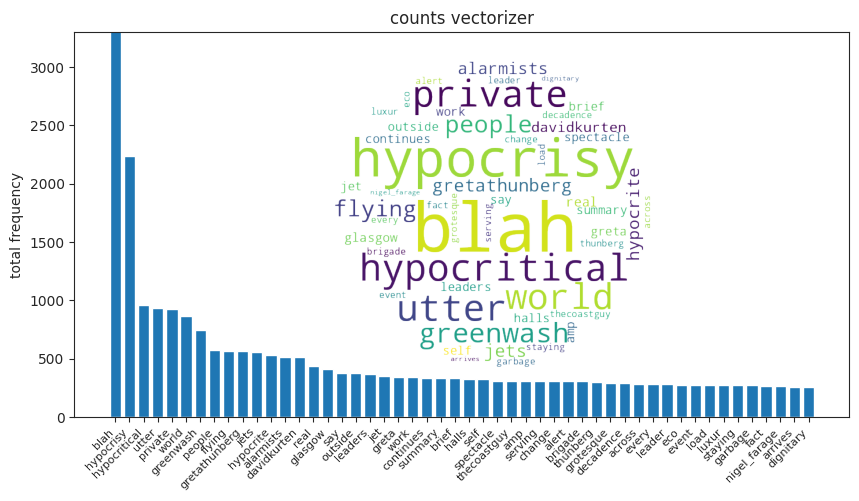

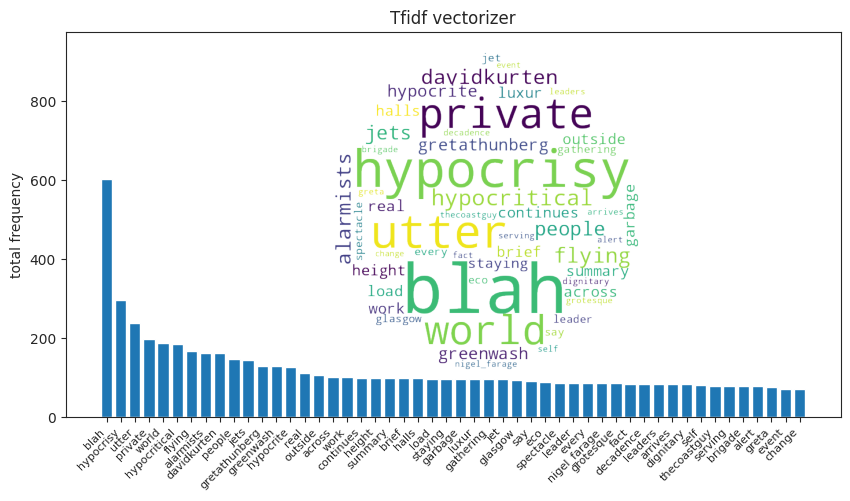

In [58]:
ngram_range=(1,1) #start and end number of words
vectorized_data_dict,feature_names=vectorize(hyp_tweets,ngram_range=ngram_range,remove_words=remove_words,min_doc_freq=min_doc_freq)
for vectorizer_type in vectypes:
    plot_wordcloud_and_freqdist(vectorized_data_dict[vectorizer_type],vectorizer_type,feature_names)

Note how the TFidf vectorizer has scaled down the hypocrisy words relative to the count vectorizer. 

There are some words here that look like they likely would appear in pairs. Let's tell the vectorizer to also look for high frequency *pairs* of words.

vocabulary size:3409
vocabulary size:3409


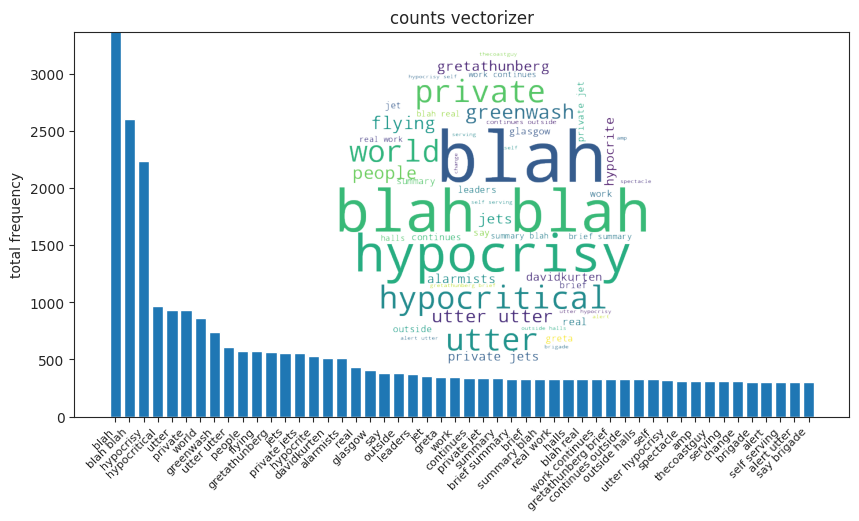

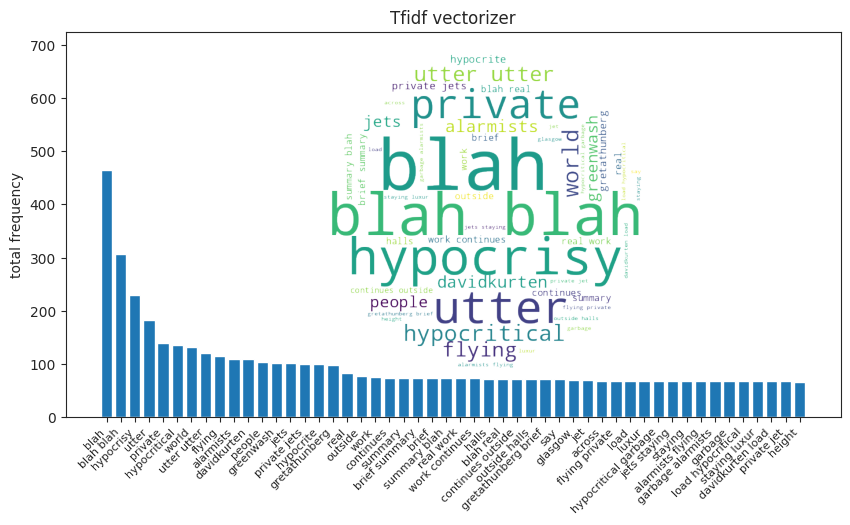

In [60]:
ngram_range= (1,2)#start and end number of words
vectorized_data_dict,feature_names=vectorize(hyp_tweets,ngram_range=ngram_range,remove_words=remove_words,min_doc_freq=min_doc_freq)
for vectorizer_type in vectypes:
    plot_wordcloud_and_freqdist(vectorized_data_dict[vectorizer_type],vectorizer_type,feature_names)

To clear this list a bit more, let's also remove the hypocrisy words altogether.




In [61]:
remove_words += hypocrisy_words

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['green', 'wash'] not in stop_words.
  warnings.warn(


vocabulary size:3203


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['green', 'wash'] not in stop_words.
  warnings.warn(


vocabulary size:3203


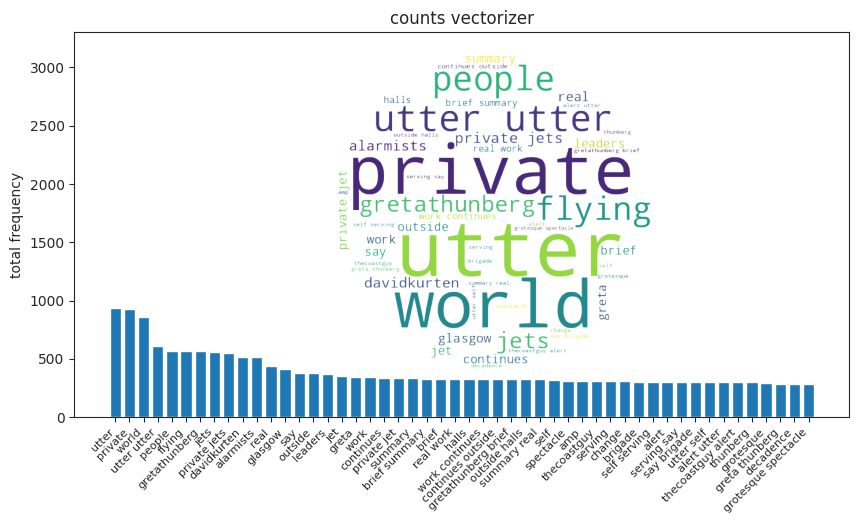

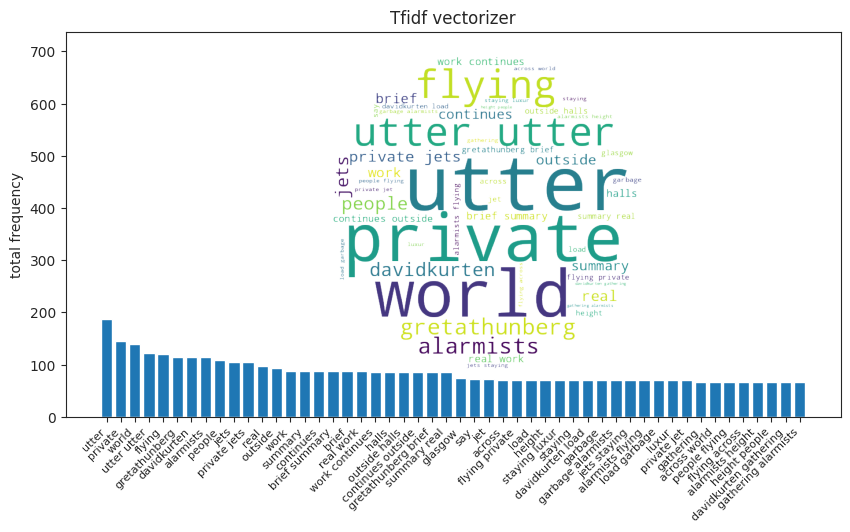

In [62]:
ngram_range= (1,2)#start and end number of words
vectorized_data_dict,feature_names=vectorize(hyp_tweets,ngram_range=ngram_range,remove_words=remove_words,min_doc_freq=min_doc_freq)
for vectorizer_type in vectypes:
    plot_wordcloud_and_freqdist(vectorized_data_dict[vectorizer_type],vectorizer_type,feature_names)

Observe terms that we might have expected are associated to hypocrisy, e.g. "flying". Even when allowing for pairs, the semantics are hard to extract from this analysis that ignores the correlations in usage among multiple words. 

To futher assess statistics, one approach is use a generative model with latent structure.

Topic models (the [structural topic model](https://www.structuraltopicmodel.com/) in particular) are a nice modelling framework to start analyzing those correlations.